## Package Installation

In [1]:
!pip install -e /home/aku7cf/DREAMS/DREAMS_python
# !pip install -e /path/to/DREAMS_python

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/aku7cf/DREAMS/DREAMS_python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dreams_python (pyproject.toml) ... done
  Created wheel for dreams_python: filename=dreams_python-0.1.0-0.editable-py3-none-any.whl size=4485 sha256=f598e10a05e8cce23452678e872424873d08a9ea09d64b1de68e49fafcf87001
  Stored in directory: /tmp/pip-ephem-wheel-cache-eyr_hev6/wheels/93/9c/36/d4c59b3fc31ec2b5dc143e4a986198ab2224d05d41a91e194c
Successfully built dreams_python
  Attempting uninstall: dreams_python
    Found existing installation: dreams_python 0.1.0
    Uninstalling dreams_python-0.1.0:
      Successfully uninstalled dreams_python-0.1.0


In [2]:
import dreams_python
import numpy as np
import matplotlib.pyplot as plt

# Goal: Visualize our halo

First things, first... let's find our halo of interest in simulation 4

In [3]:
mvs = dreams_python.DREAMS('/standard/DREAMS') ## default is mass varied suite (CDM/varied_mass/SB6/)

In [4]:
run  = 4  ## load simulation number 4
snap = 90 ## load snapshot 90 (z=0)

In [5]:
params, header = mvs.read_param_file('TNG_SB6.txt')

target_masses = params[:, 0]

fof_idx = mvs.get_target_fof_index(run, snap, target_masses[run])
grp_cat = mvs.read_group_catalog(run, snap)
h = mvs.get_h(run, snap)
scf = mvs.get_scf(run, snap)

In [6]:
print('About our target:')
print('\t',f'Halo Mass: {np.log10(grp_cat["GroupMass"][fof_idx]*1.00E+10/h):0.3f}')
print('\t',f'Total Stellar Mass: {np.log10(grp_cat["GroupMassType"][fof_idx,4]*1.00E+10/h):0.3f}')
print('\t',f'Total Gas Mass: {np.log10(grp_cat["GroupMassType"][fof_idx,0]*1.00E+10/h):0.3f}')
print('\t',f'Galaxy Center: {grp_cat['GroupPos'][fof_idx]*scf/h}')

About our target:
	 Halo Mass: 10.646
	 Total Stellar Mass: 7.860
	 Total Gas Mass: 9.374
	 Galaxy Center: [45785.5525854  40768.04824323 36636.49203032]


There are a few ways that we can visualize our halo. 

1. Loading in the entire simulation
2. Loading in only our FoF group
3. Loading in only a single subhalo

## 1. Loading in the entire simulation

This is identical to just loading in the particle data from the first tutorial

In [80]:
prt_cat = mvs.read_snapshot(run, snap, part_types=[1, 2]) ## just going to do dark matter

center = grp_cat['GroupPos'][fof_idx] * scf/h

prt1_coords = prt_cat['PartType1/Coordinates'] * scf/h
prt2_coords = prt_cat['PartType2/Coordinates'] * scf/h

prt1_coords -= center
prt2_coords -= center

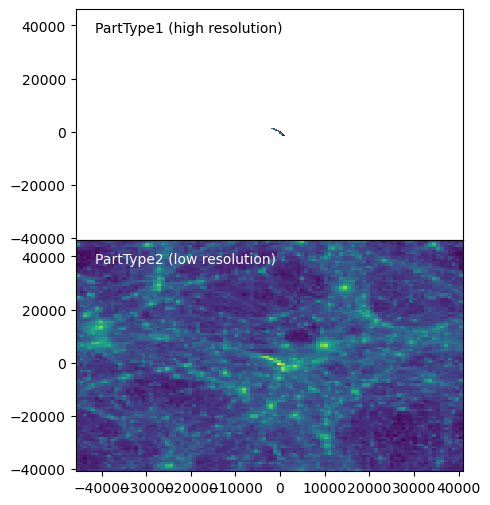

In [81]:
fig, axs = plt.subplots(2, 1, figsize=(5,6), sharex=True, sharey=True)

axs[0].hist2d(prt1_coords[:, 0], prt1_coords[:, 1], bins=100, norm='log', rasterized=True)
axs[1].hist2d(prt2_coords[:, 0], prt2_coords[:, 1], bins=100, norm='log', rasterized=True)

plt.text(0.05,0.9,'PartType1 (high resolution)',transform=axs[0].transAxes)
plt.text(0.05,0.9,'PartType2 (low resolution)',transform=axs[1].transAxes,color='white')

plt.subplots_adjust(hspace=0.0)
plt.show()

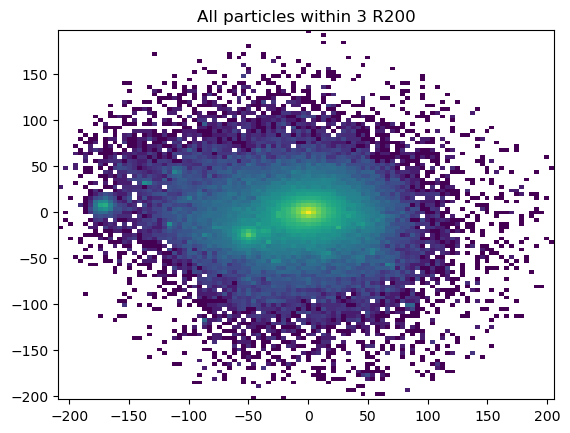

Number of particles within 3 R200: 121781


In [82]:
size = grp_cat['Group_R_Crit200'][fof_idx] * scf/h

prt1_rad = np.sqrt(prt1_coords[:,0]**2 + prt1_coords[:,1]**2 + prt1_coords[:,2]**2)
prt2_rad = np.sqrt(prt2_coords[:,0]**2 + prt2_coords[:,1]**2 + prt2_coords[:,2]**2)

prt1_mask = prt1_rad < 3 * size
prt2_mask = prt2_rad < 3 * size

prt1_coords = prt1_coords[prt1_mask, :]
prt2_coords = prt2_coords[prt2_mask, :]

all_coords = np.concatenate([prt1_coords, prt2_coords])

plt.hist2d(all_coords[:,0], all_coords[:,1], bins=100, norm='log', rasterized=True)

plt.title('All particles within 3 R200')

xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()

plt.subplots_adjust(hspace=0.0)
plt.show()

print('Number of particles within 3 R200:',all_coords[:,0].shape[0])

## 2. Load in only FoF group

In [83]:
my_fof = mvs.load_single_halo(run, snap, fof_idx=fof_idx, part_types=[1, 2])

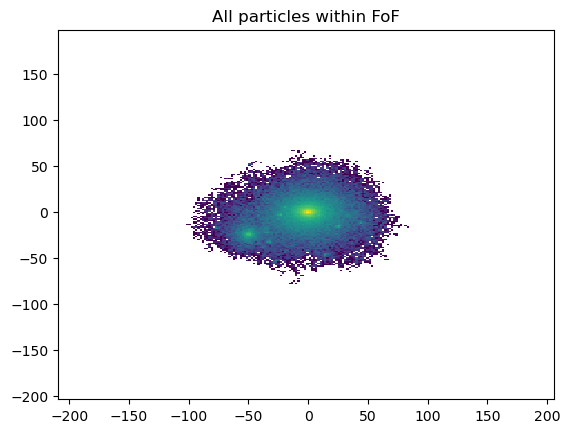

Number of particles within FoF: 99387


In [84]:
center = grp_cat['GroupPos'][fof_idx] * scf/h

prt1_coords = my_fof['PartType1/Coordinates'] * scf/h
prt2_coords = my_fof['PartType2/Coordinates'] * scf/h

prt1_coords -= center

if len(prt2_coords) > 0: ## sometimes the halos don't have any low res dm particles
    prt2_coords -= center
    
    all_coords = np.concatenate([prt1_coords, prt2_coords])
else:
    all_coords = prt1_coords

plt.hist2d(all_coords[:,0], all_coords[:,1], bins=100, norm='log', rasterized=True)

plt.title('All particles within FoF')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplots_adjust(hspace=0.0)
plt.show()

n_fof = all_coords[:,0].shape[0]

print('Number of particles within FoF:',all_coords[:,0].shape[0])

As you can see, there are a lot less particles in the FoF group than within 3$\times R_{200}$

## 3. Central Only (or satellites only)

In [85]:
central_idx = grp_cat['GroupFirstSub'][fof_idx]
my_central = mvs.load_single_subhalo(run, snap, sub_idx=central_idx, part_types=[1, 2])

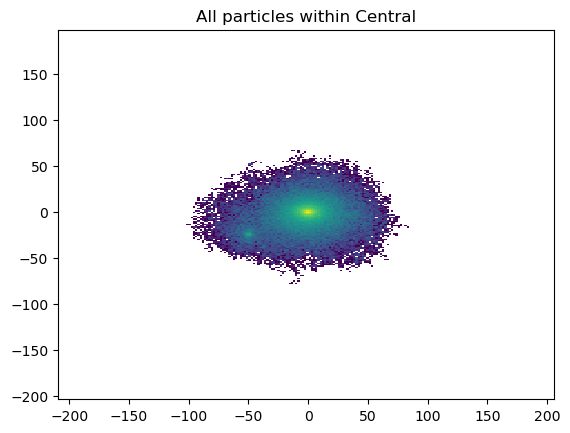

Number of particles within Central: 94589


In [86]:
center = grp_cat['GroupPos'][fof_idx] * scf/h

prt1_coords = my_central['PartType1/Coordinates'] * scf/h
prt2_coords = my_central['PartType2/Coordinates'] * scf/h

prt1_coords -= center

if len(prt2_coords) > 0: ## sometimes the halos don't have any low res dm particles
    prt2_coords -= center
    
    all_coords = np.concatenate([prt1_coords, prt2_coords])
else:
    all_coords = prt1_coords

plt.hist2d(all_coords[:,0], all_coords[:,1], bins=100, norm='log', rasterized=True)

plt.title('All particles within Central')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplots_adjust(hspace=0.0)
plt.show()

n_central = all_coords[:,0].shape[0]

print('Number of particles within Central:',all_coords[:,0].shape[0])

In [87]:
print('Number of Satellites: ',grp_cat['GroupNsubs'][fof_idx] - 1)

Number of Satellites:  22


[[-49.31011633 -23.95822026 -48.24719116]
 [-50.39283    -23.82818154 -50.06490628]
 [-50.01402157 -24.42466348 -49.2281354 ]
 ...
 [-28.07988222 -22.89246816 -69.87602222]
 [-25.75614687 -24.5744907  -71.9170647 ]
 [-27.74913157 -25.8579163  -73.03370151]]


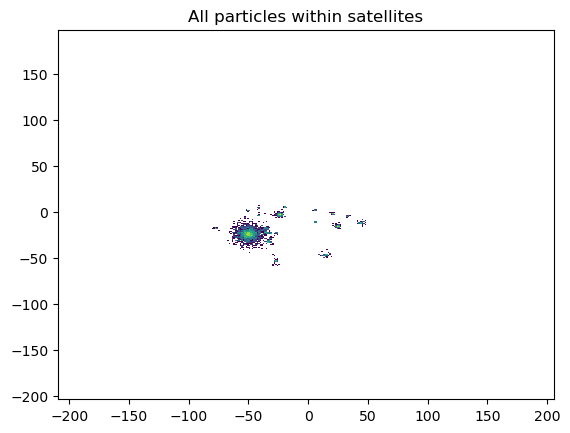

Number of particles within satellites: 4798


In [115]:
central_idx = grp_cat['GroupFirstSub'][fof_idx]
nsubs = grp_cat['GroupNsubs'][fof_idx]

prt1_list = []
prt2_list = []

for sat_id in range(central_idx+1, central_idx + nsubs):
    assert(grp_cat['SubhaloGrNr'][sat_id] == fof_idx)
    this_sub = mvs.load_single_subhalo(run, snap, sub_idx=sat_id, part_types=[1, 2])

    p1 = this_sub['PartType1/Coordinates'] * scf / h
    if p1 is not None and p1.ndim == 2 and p1.shape[1] == 3:
        prt1_list.append(p1)

    p2 = this_sub['PartType2/Coordinates'] * scf / h
    if p2 is not None and p2.ndim == 2 and p2.shape[1] == 3:
        prt2_list.append(p2)

prt1_coords = np.concatenate(prt1_list, axis=0)
prt1_coords -= center

if len(prt2_list) > 0:
    prt2_coords = np.concatenate(prt2_list, axis=0)
    prt2_coords -= center

    all_coords = np.concatenate([prt1_coords, prt2_coords])
else:
    all_coords = prt1_coords

print(all_coords)

plt.hist2d(all_coords[:,0], all_coords[:,1], bins=100, norm='log', rasterized=True)

plt.title('All particles within satellites')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplots_adjust(hspace=0.0)
plt.show()

n_sat = all_coords[:,0].shape[0]

print('Number of particles within satellites:',all_coords[:,0].shape[0])

In [117]:
print(n_fof)
print(n_sat + n_central)
assert( n_fof == (n_sat + n_central )  )

99387
99387


Note that the total number of particle in the central + satellites should be the same number as the whole FoF group!